In [1]:
import numpy as np
import einops as ein
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions.categorical import Categorical
from kilroyplot.plot import plt
from tqdm import tqdm

In [2]:
evaluate = lambda x: -len(x)

In [3]:
class Actor(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, out_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, out_dim)
        
    def forward(self, x):
        x = self.embedding(x)
        out, _ = self.lstm(x)
        y = self.linear(out)
        return F.softmax(y, dim=-1)

In [4]:
class Critic(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = self.embedding(x)
        _, (ht, _) = self.lstm(x)
        return self.linear(ht[-1])

In [5]:
class Generator:
    def __init__(self, model, start_word, end_word, max_length=10):
        self.model = model
        self.start_word = start_word
        self.end_word = end_word
        self.max_length = max_length
        
    def generate(self):
        next_word = self.start_word
        x = torch.tensor([next_word]).unsqueeze(0)
        i = 0
        while next_word != self.end_word and i < self.max_length:
            probs = self.model(x)[0][-1]
            next_word = Categorical(probs).sample()
            x = torch.cat([x, torch.tensor([next_word]).unsqueeze(-1)], dim=-1)
            i += 1
        return x[0]

In [6]:
start_word, stop_word = 0, 1
vocab_size = 5
embedding_dim, hidden_dim, out_dim = 16, 16, vocab_size

In [7]:
actor = Actor(vocab_size, embedding_dim, hidden_dim, out_dim)
critic = Critic(vocab_size, embedding_dim, hidden_dim)

In [8]:
generator = Generator(actor, start_word, stop_word)

In [9]:
actor_optimizer = optim.Adam(actor.parameters(), lr=0.001)
critic_optimizer = optim.Adam(critic.parameters(), lr=0.001)

In [10]:
criterion = nn.MSELoss()

In [11]:
epochs = 100
actor_iters = 1000
critic_iters = 100

In [12]:
critic_losses = []
actor_rewards = []

for _ in tqdm(range(epochs)):
    critic_epoch_losses = []
    critic_optimizer.zero_grad()
    for _ in range(critic_iters):
        sentence = generator.generate().unsqueeze(0)
        pred_reward = critic(sentence)
        real_reward = torch.tensor([[evaluate(s.tolist())] for s in sentence]).float()
        loss = criterion(pred_reward, real_reward)
        loss.backward()
        critic_epoch_losses.append(loss.item())
    critic_optimizer.step()
    critic_losses.append(np.mean(critic_epoch_losses))
    
    actor_epoch_rewards = []
    actor_optimizer.zero_grad()
    for _ in range(actor_iters):
        sentence = generator.generate().unsqueeze(0)
        reward = critic(sentence)
        preds = actor(sentence)
        probs = torch.gather(preds, -1, sentence.unsqueeze(-1)).squeeze(-1)
        loss = -(reward * torch.log(probs).mean())
        loss.backward()
        actor_epoch_rewards.append(reward.item())
    actor_optimizer.step()
    actor_rewards.append(np.mean(actor_epoch_rewards))

100%|██████████| 100/100 [15:01<00:00,  9.01s/it]


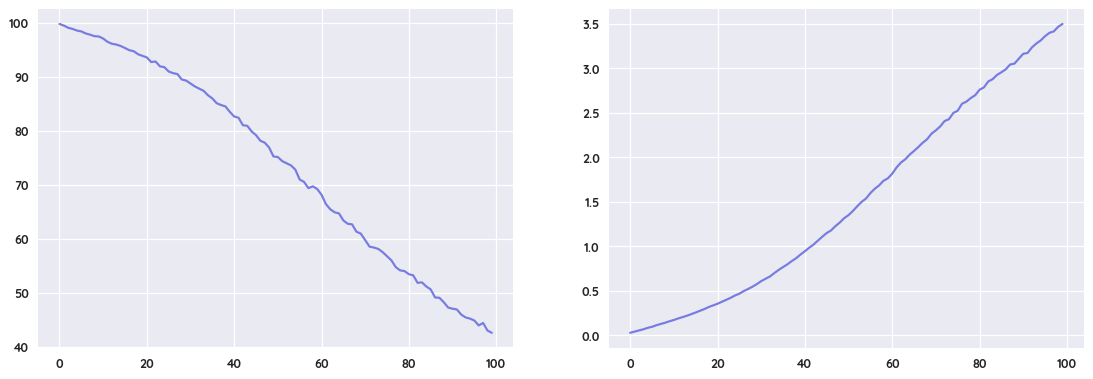

In [13]:
_, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].plot(critic_losses)
axs[1].plot(actor_rewards)

In [14]:
for sentence in [generator.generate().tolist() for _ in range(20)]:
    print(f"Sentence: {sentence}, critic score, {critic(torch.tensor([sentence])).item():.3f}, real score: {evaluate(sentence):.3f}")

Sentence: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], critic score, 3.650, real score: 10.000
Sentence: [0, 4, 4, 4, 4, 4, 4, 2, 1], critic score, 3.529, real score: 10.000
Sentence: [0, 0, 3, 4, 0, 4, 0, 1], critic score, 3.567, real score: 10.000
Sentence: [0, 0, 4, 0, 4, 4, 4, 0, 0, 4, 1], critic score, 3.559, real score: 10.000
Sentence: [0, 0, 0, 0, 4, 4, 3, 1], critic score, 3.542, real score: 10.000
Sentence: [0, 0, 1], critic score, 3.192, real score: 10.000
Sentence: [0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0], critic score, 3.650, real score: 10.000
Sentence: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], critic score, 3.650, real score: 10.000
Sentence: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], critic score, 3.650, real score: 10.000
Sentence: [0, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0], critic score, 3.650, real score: 10.000
Sentence: [0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0], critic score, 3.650, real score: 10.000
Sentence: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], critic score, 3.650, real score: 10.000
Sentence: [0, 1], critic sco